[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Humboldt-WI/bads/blob/master/tutorials/interpretable_ml.ipynb) 


# BADS - Interpretable Machine Learning

In [1]:
# Import standard packages. We import specific packages later when we first need them.
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib inline


In [6]:
# Load the data for this tutorial directly from GitHub
data_url = 'https://raw.githubusercontent.com/Humboldt-WI/bads/master/data/hmeq_modeling.csv'

print('Fetching data...')
df = pd.read_csv(data_url)
df.info() 

Fetching data...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5960 entries, 0 to 5959
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        5960 non-null   int64  
 1   BAD               5960 non-null   bool   
 2   LOAN              5960 non-null   float64
 3   MORTDUE           5960 non-null   float64
 4   VALUE             5960 non-null   float64
 5   YOJ               5960 non-null   float64
 6   CLAGE             5960 non-null   float64
 7   NINQ              5960 non-null   float64
 8   CLNO              5960 non-null   float64
 9   DEBTINC           5960 non-null   float64
 10  DEROGzero         5960 non-null   bool   
 11  REASON_HomeImp    5960 non-null   int64  
 12  REASON_IsMissing  5960 non-null   int64  
 13  JOB_Office        5960 non-null   int64  
 14  JOB_Other         5960 non-null   int64  
 15  JOB_ProfExe       5960 non-null   int64  
 16  JOB_Sales         5960 no

In [10]:
df.iloc[:, 2:df.shape[1]].values

array([[-1.8322830212305938, -1.2958822108106054, -1.3355262990291883,
        ..., 0, 0, 0],
       [-1.8106655806312384, -0.013473612226342531, -0.6726987307007986,
        ..., 0, 0, 1],
       [-1.7890481400318832, -1.654549200571461, -1.8392752509587644,
        ..., 0, 0, 0],
       ...,
       [2.5452487001389033, -0.4779995970234118, -0.1193307890604435,
        ..., 0, 0, 0],
       [2.5452487001389033, -0.5846420879110448, -0.14331668540539935,
        ..., 0, 0, 0],
       [2.5452487001389033, -0.6298817187392951, -0.2093625166393465,
        ..., 0, 0, 0]], dtype=object)

## Model development and evaluation

Many relevant modeling functions expect an input in the form $(y, X)$, where $y$ denotes the target variable and $X$ the covariates. We build these items from our prepared data frame and use them in the reminder.

In [33]:
y = df.BAD.values
X = df.iloc[:, 2:df.shape[1]].values
X_var_labels = df.columns[2:df.shape[1]]
y.shape, X.shape

((5960,), (5960, 18))

In [ ]:
X_var_labels

Index(['LOAN', 'MORTDUE', 'VALUE', 'YOJ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC',
       'DEROGzero', 'REASON_HomeImp', 'REASON_IsMissing', 'JOB_Office',
       'JOB_Other', 'JOB_ProfExe', 'JOB_Sales', 'JOB_Self', 'DELINQcat_1',
       'DELINQcat_1+'],
      dtype='object')

In [12]:
# Data partitioning
from sklearn.model_selection import train_test_split

# create training and test set
# x_train = all columns but 'BAD' of training set (needed to build supervised learning model)
# y_train = outcome variable of training observations (needed to build supervised learning model)
# x_test = all columns but 'BAD' of test set (needed to predict outcome of test set with training set model)
# y_test = outcome variable of test observations (needed for model assessment)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3 )  # 30% of the data as hold-out

#make yourself familiar with these vectors
y_train.shape, x_train.shape, y_test.shape, x_test.shape

((4172,), (4172, 18), (1788,), (1788, 18))

In [15]:
import xgboost as xgb
from sklearn.model_selection import  GridSearchCV

    # Setting up the grid of meta-parameters
xgb_param_grid = {
    'colsample_bytree': [0.7],  # random subspace
    'n_estimators': [100],  # ensemble size or number of gradient steps
    'max_depth': [5, 10],   # max depth of decision trees
    'learning_rate': [0.1, 0.01],  # learning rate
    'early_stopping_rounds': [10]}  # early stopping if no improvement after that many iterations

gs_xgb = GridSearchCV(estimator=xgb.XGBClassifier(), param_grid=xgb_param_grid, scoring='roc_auc', cv=5, verbose=1)
gs_xgb.fit(x_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:   16.0s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=None,
             param_grid={'colsample_bytree': [0.7],
                         'early_stopping_rounds': [10],
                         'learning_rate': [0.1, 0.01], 'max_depth': [

In [23]:
print("Best CV AUC: %0.4f" % gs_xgb.best_score_)

Best CV AUC: 0.9447


## 6. Feature importance analysis and model diagnosis

The interpretability of machine learning models is a big topic, because usually, the more complicated the model, the harder it will be to understand how our final predictions are computed. Especially for so called black-box models, methods have been develop to understand the importance of specific features in these models. 

### Permutation-based feature importance

Permutation-based feature importance is a learner-agnostic way to judge the relevance of features. It produces an ordinal feature ranking. In order to do this, we permute one variable by shuffling its values across all observations. This means, each observation will receive a new value. This permutation breaks the relationship to the target variable. Then we make an assumption: the higher the increase of the error due to the permutation, the more important this variable was in building the model. This way we can compute a ranking. 

Let's give it a try using our Random Forest model.

In [24]:
plt.rcParams['figure.figsize'] = 20, 10

# Permutation-based feature importance
print('Computing permutation-based feature importance...')
from sklearn.inspection import permutation_importance

classifier = gs_xgb.best_estimator_

perm_imp = permutation_importance(classifier, x_test, y_test, scoring='roc_auc', random_state=123)
sorted_idx = perm_imp.importances_mean.argsort()

Computing permutation-based feature importance...


In [30]:
x_test

array([[-0.4487668228718394, -0.21906872731175206, -0.2993265511899946,
        ..., 0, 0, 0],
       [0.4699744026007711, -1.5637217185365515, -0.9339035623933752,
        ..., 0, 1, 0],
       [-0.027226731184406376, -0.5463668646509664, 0.3936921077400422,
        ..., 0, 0, 0],
       ...,
       [0.21056511540850456, -1.5820032884030033, -0.24623265269546865,
        ..., 0, 0, 1],
       [-0.6649412288653949, -1.2743796024438745, -1.0304789493702435,
        ..., 0, 0, 0],
       [-0.3622970604744172, -0.6772977269325992, -0.6714351275067086,
        ..., 0, 0, 0]], dtype=object)

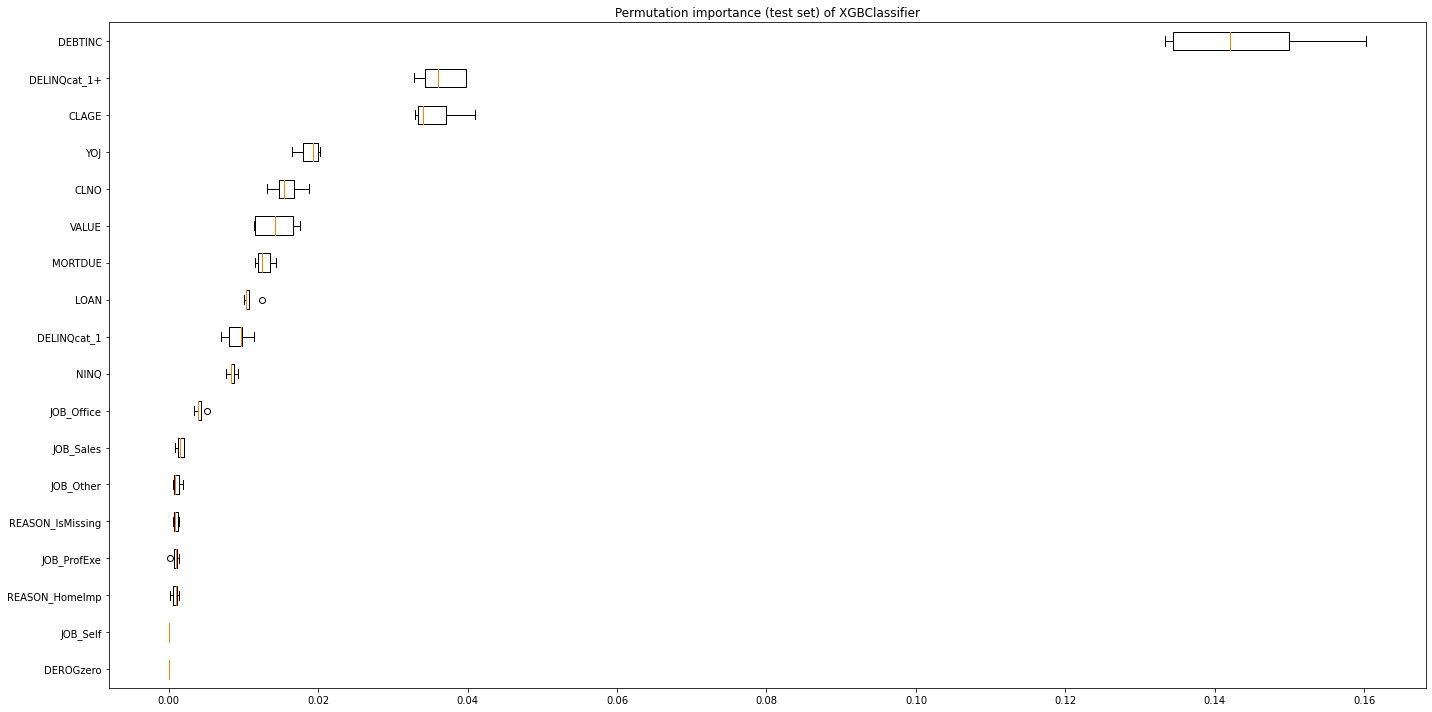

In [36]:
fig, ax = plt.subplots()
ax.boxplot(perm_imp.importances[sorted_idx].T,
           vert=False, labels=X_var_labels[sorted_idx])
ax.set_title("Permutation importance (test set) of {}".format(str(classifier)[0:str(classifier).find('(')]))
fig.tight_layout()
plt.show()

The result agrees with domain knowledge. The debt-to-income ratio proves very important. RF devotes much attention to this feature so that permuting it increases the prediction error. High importance of the number of delinquent credit lines (DELINQ) also makes sense. For CLAGE, the age of the oldest credit line in months it is maybe less obvious how it affects the target. Specifically, it would be useful to check whether high/lower values in this feature are associated with higher/lower default probability. We do not get such insight from permutation-based feature importance analysis. But partial-dependence should give as an answer.

### Partial dependence plot (PDP)
A PDP shows what type of effect a feature has on predicted probabilities. A PDP plots the values of a chosen variable (on the x-axis) against model-estimated probabilities (on the y-axis) whilst according for the combined effect of all other features. 

Computing partial dependence plots...


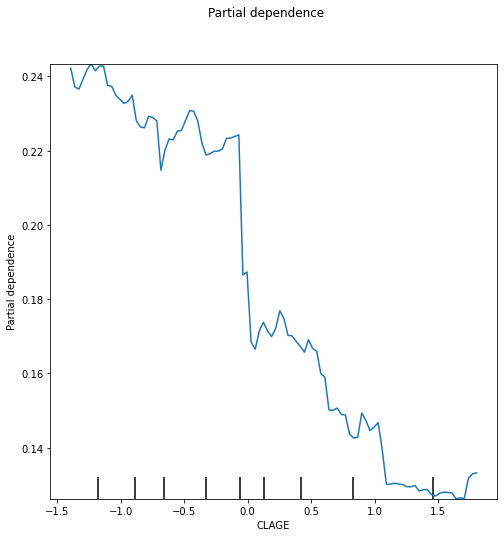

In [52]:
plt.rcParams['figure.figsize'] = 8,8
# Partial dependence
from sklearn.inspection import plot_partial_dependence
classifier = gs_xgb.best_estimator_
print('Computing partial dependence plots...')



plot_partial_dependence(classifier, x_train, features=['CLAGE'], feature_names=X_var_labels)

fig = plt.gcf()
fig.suptitle('Partial dependence')
fig.subplots_adjust(wspace=0.4, hspace=0.3)
plt.show()

Coming back to the question how CLAGE affects the PD estimates, we now have a clear answer. Higher values decrease PDs. That makes sense because high values indicate that a client has been with the bank for a longer time. We would expect such customers to be less likely to default compared to newer customers. 

As a cautionary remark, always make sure to know what exactly the y-axis is showing, the probability of being a good or a bad customer. In a binary classification setting, scikit-learn considers the class with the higher value the positive class.